In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Cargar el dataset de películas como un dataframe de pandas
movies = pd.read_csv("data/movies.csv", index_col="id")

# Convertimos estas columnas en listas para practicidad
movies[["genres_id", "actors_id", "directors_id"]] = movies[[
    "genres_id", "actors_id", "directors_id"]].apply(lambda x: x.apply(eval))

## Identificado columnas a eliminar

In [3]:
correlation_matrix = movies.corr()

/tmp/ipykernel_55650/1528385776.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = movies.corr()


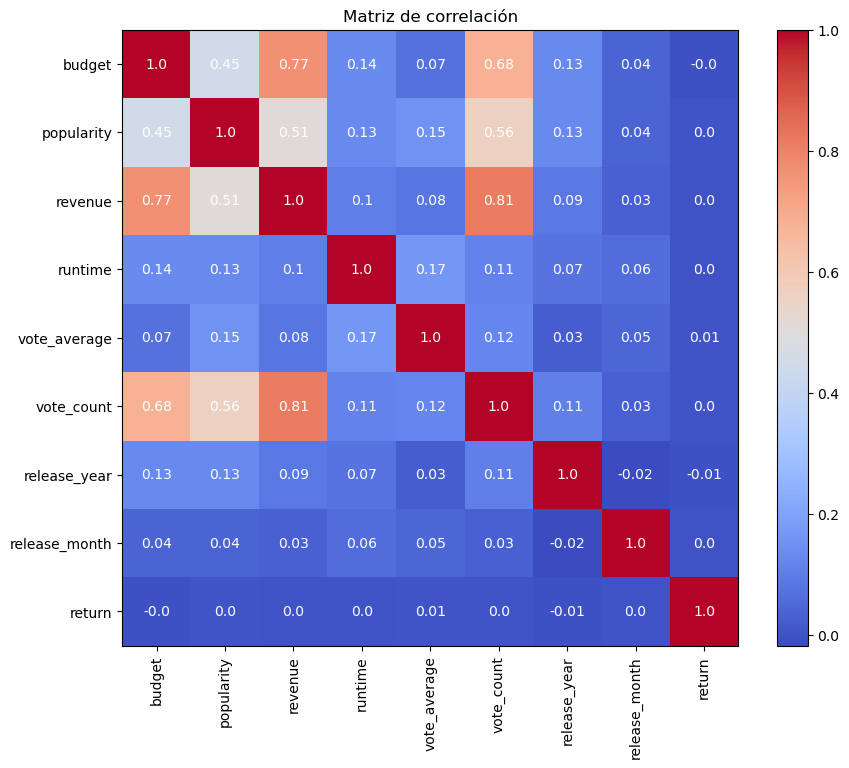

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="nearest")
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = plt.text(j, i, round(correlation_matrix.iloc[i, j], 2),
                        ha="center", va="center", color="w")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Matriz de correlación")
plt.show()

### No hay una correlación clara en ninguna de las variables

In [5]:
movies.head(2)

,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,genres_id,actors_id,directors_id,release_year,release_month,release_day,return
id,,,,,,,,,,,,,,,
862,30000000.0,21.946943,1995-10-30,373554033.0,81.0,toy story,7.7,5415,"[16, 35, 10751]","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[7879],1995,10,lunes,12.451801
8844,65000000.0,17.015539,1995-12-15,262797249.0,104.0,jumanji,6.9,2413,"[12, 14, 10751]","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...",[4945],1995,12,viernes,4.043035


In [6]:
# Nos damos cuenta que release_date, year, month y day no nos ayudarán así que se eliminan
movies = movies.drop(axis=1, columns=["release_date", "release_year", "release_month", "release_day"])
movies.head(2)

,budget,popularity,revenue,runtime,title,vote_average,vote_count,genres_id,actors_id,directors_id,return
id,,,,,,,,,,,
862,30000000.0,21.946943,373554033.0,81.0,toy story,7.7,5415,"[16, 35, 10751]","[31, 12898, 7167, 12899, 12900, 7907, 8873, 11...",[7879],12.451801
8844,65000000.0,17.015539,262797249.0,104.0,jumanji,6.9,2413,"[12, 14, 10751]","[2157, 8537, 205, 145151, 5149, 10739, 58563, ...",[4945],4.043035


In [7]:
# Vemos valores vacíos del presupuesto y retorno de la película
print(len(movies[movies["budget"]==0]))
print(len(movies[movies["revenue"]==0]))
print(len(movies[movies["return"]==0]))

36469
37948
39970


In [8]:
# Dada la cantidad de nulos tendríamos que borrar muchos datos para el modelo, así que se decide borrar estas columnas también, además las columnas de actores y directores también, ya que tienen mucha correlación con el retorno
movies = movies.drop(axis=1, columns=["budget", "revenue", "return", "actors_id", "directors_id"])

## Verificando más datos

In [9]:
movies.describe()

,popularity,runtime,vote_average,vote_count
count,45345.000000,45345.000000,45345.000000,45345.000000
mean,2.926248,93.668960,5.624320,110.137722
std,6.011023,38.863177,1.915178,491.904428
min,0.000000,0.000000,0.000000,0.000000
25%,0.388826,85.000000,5.000000,3.000000
50%,1.130269,95.000000,6.000000,10.000000
75%,3.689610,107.000000,6.800000,34.000000
max,547.488298,1256.000000,10.000000,14075.000000


In [10]:
movies.head(2)

,popularity,runtime,title,vote_average,vote_count,genres_id
id,,,,,,
862,21.946943,81.0,toy story,7.7,5415,"[16, 35, 10751]"
8844,17.015539,104.0,jumanji,6.9,2413,"[12, 14, 10751]"


Como se espera un algoritmo de recomendaciones, podemos trabajar con los géneros de las películas multiplicados por el promedio de votos, lo que creará una matriz de peso

In [11]:
# Debido a la naturaleza del modelo nos tendremos que quedar solo con las películas que tengan conteo de votos mayor o igual a 5 para al menos tener la certeza de que algunas personas la vieron
movies = movies[movies["vote_count"] >= 5]
movies

,popularity,runtime,title,vote_average,vote_count,genres_id
id,,,,,,
862,21.946943,81.0,toy story,7.7,5415,"[16, 35, 10751]"
8844,17.015539,104.0,jumanji,6.9,2413,"[12, 14, 10751]"
15602,11.712900,101.0,grumpier old men,6.5,92,"[10749, 35]"
31357,3.859495,127.0,waiting to exhale,6.1,34,"[35, 18, 10749]"
11862,8.387519,106.0,father of the bride part ii,5.7,173,[35]
...,...,...,...,...,...,...
106807,0.225432,2.0,the fat and lean wrestling match,6.5,6,"[35, 14]"
404604,1.559596,146.0,mom,6.6,14,"[80, 18, 53]"
84419,0.222814,65.0,house of horrors,6.3,8,"[27, 9648, 53]"


In [12]:
movies.describe()

,popularity,runtime,vote_average,vote_count
count,30876.000000,30876.000000,30876.000000,30876.000000
mean,4.128831,98.339034,6.090750,160.851568
std,6.951266,35.670790,1.072599,589.324551
min,0.000001,0.000000,0.000000,5.000000
25%,1.010781,88.000000,5.500000,9.000000
50%,2.186994,97.000000,6.200000,20.000000
75%,5.885291,110.000000,6.800000,66.000000
max,547.488298,1256.000000,9.600000,14075.000000


In [13]:
# Crearemos unas columnas de confianza para que las películas con más votos tengan más peso en el modelo
movies["vote_confidence"] = pd.cut(movies["vote_count"], bins=[0, 20, 40, 60, 80, float("inf")], labels=[1, 2, 3, 4, 5])
movies["popularity_confidence"] = pd.cut(movies["popularity"], bins=[0, 1.2, 2.4, 3.6, 4.8, float("inf")], labels=[1, 2, 3, 4, 5])
movies

,popularity,runtime,title,vote_average,vote_count,genres_id,vote_confidence,popularity_confidence
id,,,,,,,,
862,21.946943,81.0,toy story,7.7,5415,"[16, 35, 10751]",5,5
8844,17.015539,104.0,jumanji,6.9,2413,"[12, 14, 10751]",5,5
15602,11.712900,101.0,grumpier old men,6.5,92,"[10749, 35]",5,5
31357,3.859495,127.0,waiting to exhale,6.1,34,"[35, 18, 10749]",2,4
11862,8.387519,106.0,father of the bride part ii,5.7,173,[35],5,5
...,...,...,...,...,...,...,...,...
106807,0.225432,2.0,the fat and lean wrestling match,6.5,6,"[35, 14]",1,1
404604,1.559596,146.0,mom,6.6,14,"[80, 18, 53]",1,2
84419,0.222814,65.0,house of horrors,6.3,8,"[27, 9648, 53]",1,1


In [14]:
# Cambiamos de tipo a vote_confidence y a popularity_confidence para sacar la columna score
movies["vote_confidence"] = movies["vote_confidence"].astype(int)
movies["popularity_confidence"] = movies["popularity_confidence"].astype(int)

In [15]:
movies

,popularity,runtime,title,vote_average,vote_count,genres_id,vote_confidence,popularity_confidence
id,,,,,,,,
862,21.946943,81.0,toy story,7.7,5415,"[16, 35, 10751]",5,5
8844,17.015539,104.0,jumanji,6.9,2413,"[12, 14, 10751]",5,5
15602,11.712900,101.0,grumpier old men,6.5,92,"[10749, 35]",5,5
31357,3.859495,127.0,waiting to exhale,6.1,34,"[35, 18, 10749]",2,4
11862,8.387519,106.0,father of the bride part ii,5.7,173,[35],5,5
...,...,...,...,...,...,...,...,...
106807,0.225432,2.0,the fat and lean wrestling match,6.5,6,"[35, 14]",1,1
404604,1.559596,146.0,mom,6.6,14,"[80, 18, 53]",1,2
84419,0.222814,65.0,house of horrors,6.3,8,"[27, 9648, 53]",1,1


In [16]:
# Traemos el diccionario de género
genres = pd.read_csv("data/genres.csv", index_col="genre").to_dict(
    orient="dict")["id"]
genres

{'animation': 16,
 'comedy': 35,
 'family': 10751,
 'adventure': 12,
 'fantasy': 14,
 'romance': 10749,
 'drama': 18,
 'action': 28,
 'crime': 80,
 'thriller': 53,
 'horror': 27,
 'history': 36,
 'science fiction': 878,
 'mystery': 9648,
 'war': 10752,
 'foreign': 10769,
 'music': 10402,
 'documentary': 99,
 'western': 37,
 'tv movie': 10770}

In [17]:
# Hacemos el one hot encoding de todos los géneros
for k, v in genres.items():
    movies[k] = movies["genres_id"].apply(lambda arr: v in arr).astype(int)
movies = movies.drop(axis=1, columns="genres_id")
movies

,popularity,runtime,title,vote_average,vote_count,vote_confidence,popularity_confidence,animation,comedy,family,...,horror,history,science fiction,mystery,war,foreign,music,documentary,western,tv movie
id,,,,,,,,,,,,,,,,,,,,,
862,21.946943,81.0,toy story,7.7,5415,5,5,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8844,17.015539,104.0,jumanji,6.9,2413,5,5,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15602,11.712900,101.0,grumpier old men,6.5,92,5,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31357,3.859495,127.0,waiting to exhale,6.1,34,2,4,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11862,8.387519,106.0,father of the bride part ii,5.7,173,5,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106807,0.225432,2.0,the fat and lean wrestling match,6.5,6,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
404604,1.559596,146.0,mom,6.6,14,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84419,0.222814,65.0,house of horrors,6.3,8,1,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [18]:
# Sacamos las columnas de género
genre_columns = ["animation", "comedy", "family", "adventure", "fantasy",
        "romance", "drama", "action", "crime", "thriller", "horror", "history",
        "science fiction", "mystery", "war", "foreign", "music", "documentary",
        "western", "tv movie"]

In [19]:
# Construimos la matriz de peso
weight_matrix = movies[genre_columns].mul(movies["vote_average"], axis=0)
# Añadimos las columnas de confianza para mejorar el modelo
weight_matrix["vote_confidence"] = movies["vote_confidence"]
weight_matrix["popularity_confidence"] = movies["popularity_confidence"]
weight_matrix

,animation,comedy,family,adventure,fantasy,romance,drama,action,crime,thriller,...,science fiction,mystery,war,foreign,music,documentary,western,tv movie,vote_confidence,popularity_confidence
id,,,,,,,,,,,,,,,,,,,,,
862,7.7,7.7,7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
8844,0.0,0.0,6.9,6.9,6.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
15602,0.0,6.5,0.0,0.0,0.0,6.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
31357,0.0,6.1,0.0,0.0,0.0,6.1,6.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4
11862,0.0,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106807,0.0,6.5,0.0,0.0,6.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
404604,0.0,0.0,0.0,0.0,0.0,0.0,6.6,0.0,6.6,6.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
84419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.3,...,0.0,6.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1


### Tenemos todo listo, así que ahora podemos crear nuestro modelo

In [20]:
# Creamos la función de recomendación para el usuario
from sklearn.metrics.pairwise import cosine_similarity

def recomendation(title: str):
    """Ingresas un nombre de pelicula y te recomienda las similares en una lista"""
    title = title.lower()
    # Buscamos la película en el df de películas
    movie_id = movies.loc[movies["title"] == title].index

    # Si la a película no existe en el DataFrame se devuelve nulo
    if movie_id.empty:
        return {"lista recomendada": None}

    # Hacemos un reshape para poder sacar la correlación con cosine_sim
    movie = weight_matrix.loc[movie_id].to_numpy().reshape(1, -1)

    # Calculamos la similitud de coseno entre la película ingresada por el usuario y todas las demás películas
    cosine_sim = cosine_similarity(movie, weight_matrix)

    # Obtenemos los 5 índices de las películas más similares excluyendo la primera que es la que ingresa el usuario
    similar_movies = cosine_sim.argsort()[0][::-1][1:6]

    recomendation_list = []
    # Obtenemos los títulos de las películas similares y los añadimos a la lista de recomendación
    for i in similar_movies:
        recomendation_list.append((movies["title"].iloc[i]).title())

    return {"lista recomendada": sorted(recomendation_list)}

In [21]:
recomendation("Toy story")

{'lista recomendada': ['A Close Shave',
  'Monsters, Inc.',
  'The Wrong Trousers',
  'Toy Story 2',
  'Toy Story 3']}

### Tenemos nuestro modelo funcionando así que lo procedemos a exportar

In [22]:
weight_matrix.to_csv("data/weight_matrix.csv")

También tenemos que exportar solo los títulos para weight_matrix funcione, ya que cosine_sim no almacena índices

In [23]:
df = movies["title"]
df

id
862                              toy story
8844                               jumanji
15602                     grumpier old men
31357                    waiting to exhale
11862          father of the bride part ii
                        ...               
106807    the fat and lean wrestling match
404604                                 mom
84419                     house of horrors
30840                           robin hood
67758                             betrayal
Name: title, Length: 30876, dtype: object

In [24]:
df.to_csv("data/titles.csv", index=False)